In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Representation space. samples: 911


<Figure size 1584x432 with 0 Axes>

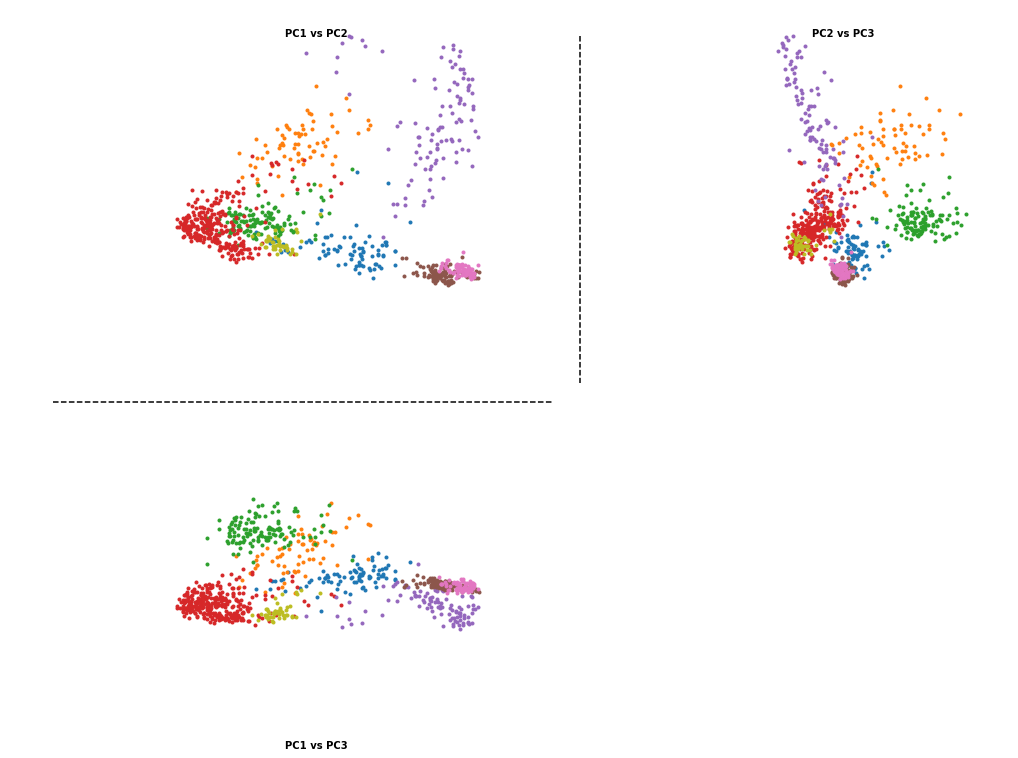

In [2]:
from dataVisualization import *
from imageUtils import *
from clusterTools import *
from removePetiole import *
from processContour import *
from clusterResults import *
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

### data source
path_data  = '/home/jorge/data/leaf_image/ImageCLEF2012/data/select_experim/'
data_file  = '../notebooks/species.xlsx' # input data file of species specifications

### sampling process
#lst_species   = ['elliptic', 'oblong', 'obovate', 'ovate']
lst_species = ['Viburnum_tinus', 'Quercus_petraea', 'Ruscus_aculeatus', 'Nerium_oleander', 'Cercis_siliquastrum', 'Capparis_spinosa', 'Daphne_cneorum', 'Celtis_australis', 'Buddleja_davidii']
lst_species = ['baseComplex', 'baseConcave', 'baseConcaveConvex', 'baseConvex', 'baseCordate', 'baseCuneate', 'baseDecurrent', 'baseRounded']
df = load_data(path_data, lst_species)
 

sz_contour  = 640
h           = 200
min_ngroups = 8
prefix      = 'results_experm/tesis/baseShape_'

num_leaves  = len(df.index)
num_species = len(lst_species)
contours    = np.zeros((num_leaves, sz_contour+1, 2))   # Concatenate contours
features    = np.zeros((num_leaves, h), dtype=complex)
signals     = []

fig = plt.figure(figsize=(22,6))
for i in range(num_leaves):
    imb = binImage(df.file[i])
    im1 = verticalStraighten(imb) 
    outl = getContour(im1)
    marks = removePetiole(im1)  
    imbody = im1[marks[3]:marks[1], :]
    imbody = bigPatchImage(imbody)

    outline = getContour(imbody)
    contour = interparc(sz_contour+1, outline)
    contours[i] = contour
    x   = contour[:,0] + contour[:,1]*1j
    dx  = np.diff(x, axis=0); 
    ndx = np.divide(dx, np.absolute(dx))
    ndk = np.fft.fft(ndx.T)
    ndk = ndk.T
    ind_harm = list(range(h//2)) + list(range(sz_contour-h//2,sz_contour))
    features[i] = ndk[ind_harm]
    
mfeat    = np.absolute(features)
#mfeat    = (mfeat - mfeat.mean(axis=0))/mfeat.std(axis=0)
pca      = PCA(n_components=5)
pca.fit(mfeat)
    
points   = pca.transform(mfeat)
points   = points / points.max()
weights  = np.cumsum(pca.explained_variance_ratio_)*100

dist     = pdist(points[:,0:3])
ndx_dist = np.argsort(dist)

arad     = alpha_radius_kde(points[:,0:3], 'exponential', 0.5)
adist    = get_alpha_dist(dist, arad)
J        = np.argsort(adist)
dTri     = Delaunay(points[:,0:3])

draw_points(points, df.cat, save=prefix+'pts.svg')

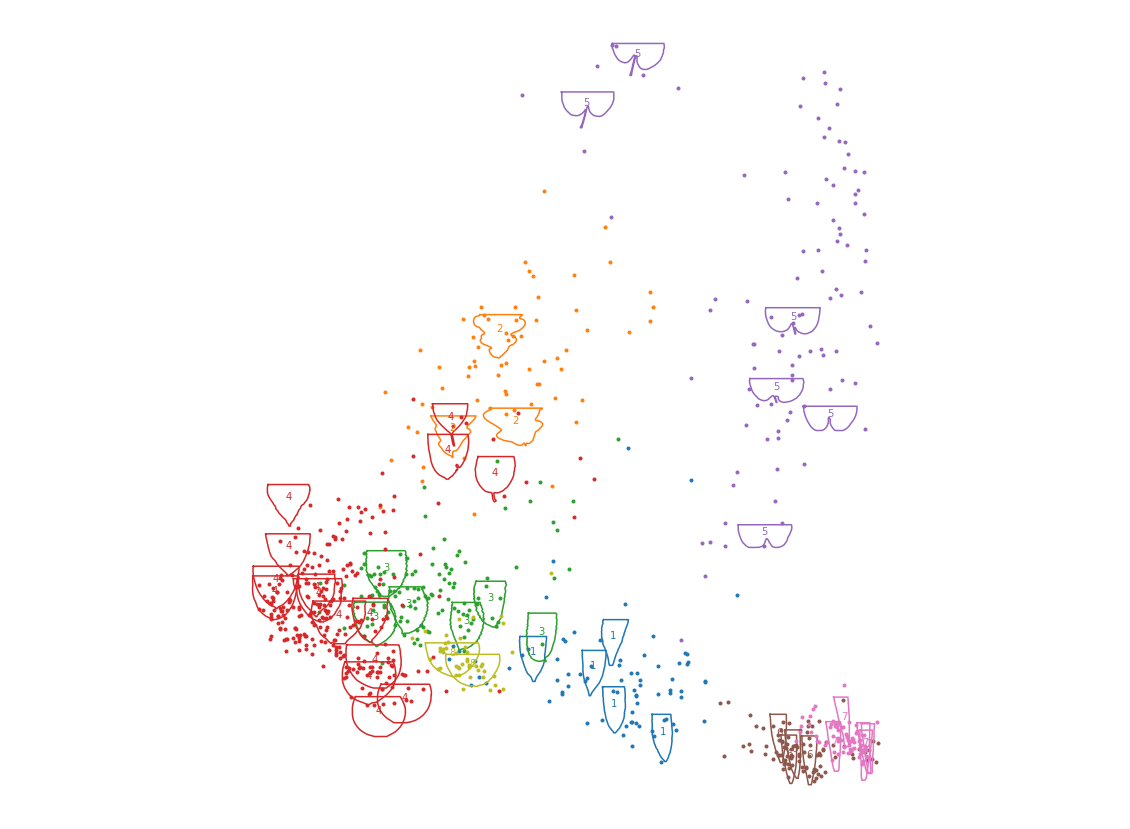

In [3]:
draw_ptsContoursInfo(points, contours, df, d1=0, d2=1, sc=0.05)

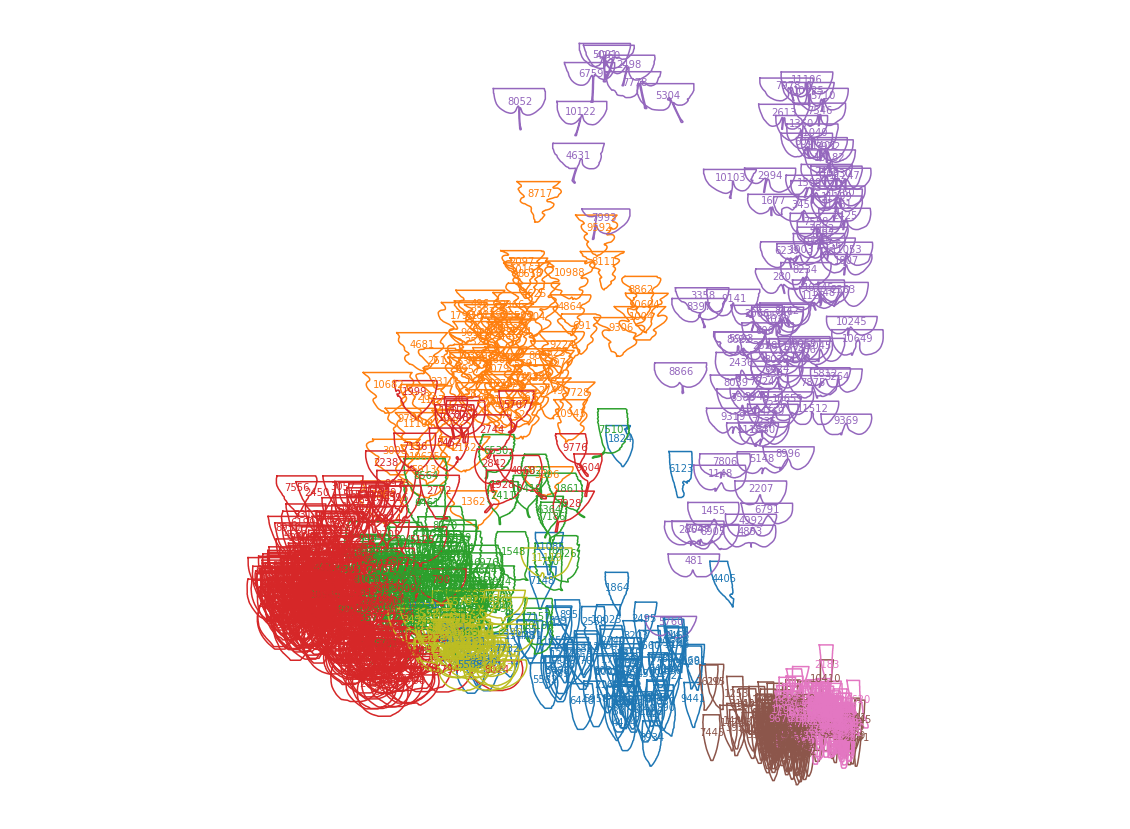

Leaves distribution in the representation space. Projection each leaf samples in the representation space


In [4]:
draw_ptsContours(points, contours, df, save=prefix+'contours.svg', d1=0, d2=1, sc=0.05)

In [5]:
dEdge = generate_edges(dTri, num_leaves)
print(datetime.datetime.now())
tinit = time.time()
data = meanshift_results2(J, num_leaves, dEdge, Q=8)
tfin = time.time()
resultsTDA = resultsTDA[:data[3],:]
print('Termino, segundos', tfin-tinit)

dfr = pd.DataFrame(resultsTDA, columns=['k', 'event', 'gr1', 'gr2'])
dfr['rend'] = adist[J[dfr.k]]*10
dfr['i_'] = dfr['k'].apply(lambda x: get_index(J[x], num_leaves)[0])
dfr['j_'] = dfr['k'].apply(lambda x: get_index(J[x], num_leaves)[1])

2022-12-13 13:34:44.234328
0 	 [ 0  0  0 -1]
100 	 [110   0  48  -1]
200 	 [246   1  33  -1]
300 	 [408   3  23 543]
400 	 [637   2   0   4]
500 	 [899   2  55 114]
600 	 [1275    1  117   -1]
700 	 [1750    3   60  890]
800 	 [2213    1  158   -1]
900 	 [2832    1  120   -1]
1000 	 [3646    5   34  651]
1100 	 [4564    5   18  392]
1200 	 [5714    4   32  252]
1300 	 [7768    5   19  162]
1400 	 [10337     5    59    60]
1500 	 [15522     1    44    -1]
1600 	 [28503     1     0    -1]
Final it = 1620 k = 40657
Termino, segundos 75.51454377174377


In [6]:
pH1 = np.array(persistArrayH1)
pH2 = np.array(persistArrayH2)
persistencePlot(adist[J[pH1[:,0]]], pH1[:,1], adist[J[pH2[:,0]]], pH2[:,1], save=prefix+'linePersist.svg')
groupsPersistPlot(adist[J[pH1[:,0]]], pH1[:,1].astype(int), adist[J[pH2[:,0]]], pH2[:,1].astype(int), save=prefix+'barPersist.svg')

In [7]:
dfr[(dfr.rend>0.36) & (dfr.rend<0.37)]

k  event  gr1  gr2      rend   i_   j_
1534  18621      5   15  666  0.360863  618  673
1535  18661      2    1  144  0.361430  283  320
1536  18687      1    1   -1  0.361703  431  484
1537  18698      5   82  122  0.361905  140  356
1538  18797      1    0   -1  0.362868   16   22
1539  18946      1  228   -1  0.364733  225  270
1540  18952      2   26   60  0.364823  643  664
1541  18957      5  107  183  0.364882  224  241
1542  18959      5   15  664  0.364912  622  643
1543  18974      5   82   96  0.365133   90  120
1544  19080      2    0    1  0.366457   45  869
1545  19098      5   15  662  0.366687  599  642
1546  19245      4   94  141  0.368443   95  150
1547  19312      5    0   29  0.369192    0   49
1548  19366      5    0   64  0.369798   45  899

In [8]:
u, f = np.unique(df.cat, return_counts=True)
for i in u: print(lst_species[i], '   \t', f[i])
print('--'*40)
H2 = groupsH2(dfr, num_leaves, 1535)
evaluation(H2, df.cat, lst_species)

baseComplex    	 84
baseConcave    	 69
baseConcaveConvex    	 124
baseConvex    	 301
baseCordate    	 104
baseCuneate    	 98
baseDecurrent    	 84
baseRounded    	 47
--------------------------------------------------------------------------------
FINAL F1 SCORE : 0.6948408342480791
---------------------------------------------------------------------------------------------------- 
CONFUSION MATRIX:


species  100  82   19   18  15   0  38  911  89  Total
0        baseComplex    7   0    0    0   0  68   0    9   0     84
1        baseConcave    0  53    0    0   0   0   0   16   0     69
2  baseConcaveConvex    0   0  108    0   0   0   0   16   0    124
3         baseConvex    0   3    0  279   0   0   0   19   0    301
4        baseCordate    0   0    0    0  86   1   9    3   5    104
5        baseCuneate    0   0    0    0   0  98   0    0   0     98
6      baseDecurrent    0   0    0    0   0  84   0    0   0     84
7        baseRounded    0   0    0   41   0   4   0    2   0     47

species  100  82   19   18  15   0  38  911  89  Total
0        baseComplex    7   0    0    0   0  68   0    9   0     84
1        baseConcave    0  53    0    0   0   0   0   16   0     69
2  baseConcaveConvex    0   0  108    0   0   0   0   16   0    124
3         baseConvex    0   3    0  279   0   0   0   19   0    301
4        baseCordate    0   0    0    0  86   1   9    3   5    104
5        baseCuneate    0   0    0    0   0  98   0    0   0     98
6      baseDecurrent    0   0    0    0   0  84   0    0   0     84
7        baseRounded    0   0    0   41   0   4   0    2   0     47

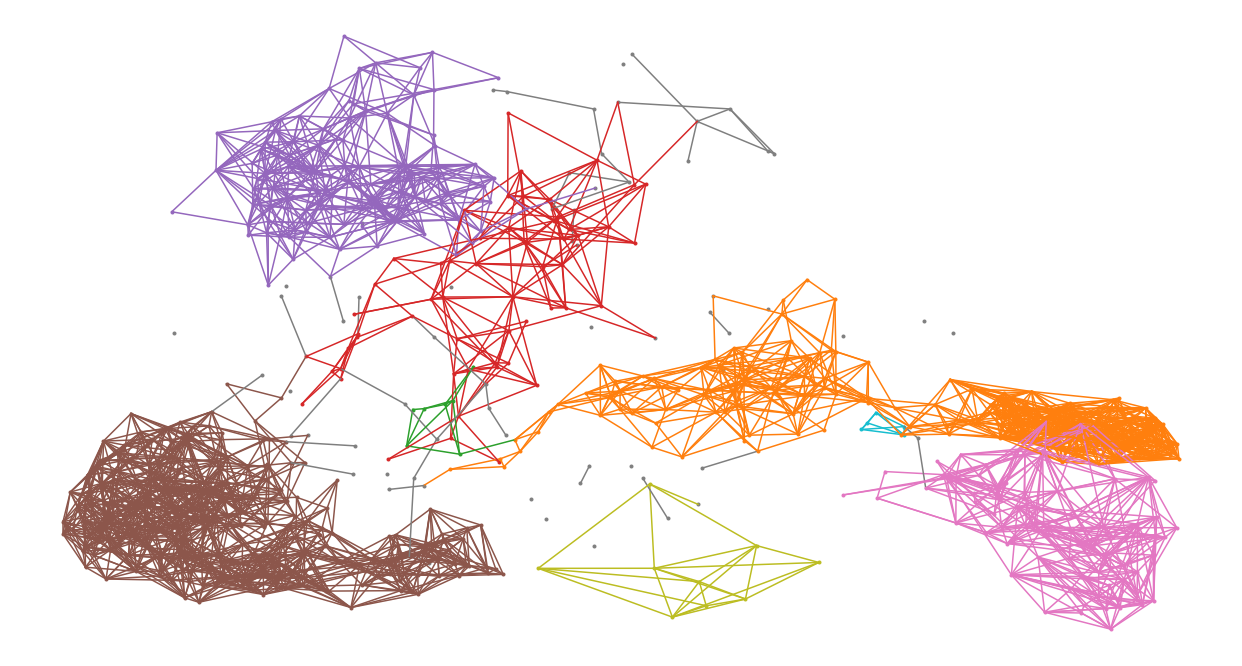

In [9]:
u, ndx = np.unique(H2, return_index=True)
ind = np.argsort(ndx)
arn = np.arange(u.size)
arn[u[ind]==num_leaves] = 23
pred = interchange(np.array(H2), u[ind], arn) 
draw_points1d(points, pred, J, num_leaves, dEdge, 18698, d1=0, d2=2, save=prefix+'pred.svg')

In [10]:
sw_disag = False #en adelante para ejecutar la des-agregación de elementos por grupo una sola vez
dfx, sam = life_groupsH2(dfr, num_leaves)
dfx.sort_values('duration', ascending=False)

group     birth      dead  qleaves  fusion  duration
1       0  0.036072  0.620526      911       0  0.584454
6      15  0.071885  0.588322      106       0  0.516437
14     19  0.103027  0.505554      123       0  0.402527
8      18  0.079895  0.388417      392       0  0.308522
31     82  0.207196  0.371282       58      18  0.164086
20     35  0.097969  0.230543       44      18  0.132575
33     38  0.249002  0.364912        9      15  0.115909
29     43  0.160838  0.272563       46       0  0.111725
28     59  0.174368  0.284442       16       0  0.110075
24     32  0.125539  0.201585       58      19  0.076046
16     54  0.125539  0.198195        9      32  0.072656
11     24  0.086334  0.156472       47      18  0.070138
30     85  0.207196  0.276095       17      82  0.068899
4       3  0.054487  0.100200       54       0  0.045713
27     45  0.163566  0.204498       15      18  0.040932
13     42  0.097969  0.138515       19      35  0.040547
2       1  0.036072  0.073331       53       0  0.037258
12     26  0.086334  0.115375       22      24  0.029041
7      28  0.079825  0.106392       14       0  0.026568
36    107  0.468480  0.491258        8      19  0.022778
32     46  0.235707  0.258289       10      43  0.022582
23     34  0.150635  0.172792       22      15  0.022157
26     57  0.162810  0.184634        8      32  0.021823
10     29  0.086334  0.106873       12      26  0.020539
21     36  0.124825  0.143687       36      18  0.018862
9      23  0.081062  0.098347       10      18  0.017285
34    102  0.270486  0.287096       11      82  0.016610
17     37  0.124825  0.139544       28      36  0.014719
25     52  0.160838  0.174823        9      43  0.013985
18     48  0.138252  0.151143       13      35  0.012891
5       7  0.055621  0.066052       15       3  0.010432
0       2  0.036072  0.045643       10       1  0.009571
35     95  0.321310  0.329154        8      82  0.007844
19     50  0.138426  0.142778        8      18  0.004352
22     61  0.142028  0.144988       12      18  0.002959
15     41  0.124825  0.126676        9      37  0.001851
3       4  0.044067  0.044376        9       1  0.000309

In [11]:
num_categ = 20
nleaves, sw_disag = disagregate_leaves(dfx, sam, num_categ, sw_disag)
dfx['qleaves'] = nleaves
dfx.sort_values('duration', ascending=False).head

<bound method NDFrame.head of     group     birth      dead  qleaves  fusion  duration
1       0  0.036072  0.620526      107       0  0.584454
6      15  0.071885  0.588322       97       0  0.516437
14     19  0.103027  0.505554       57       0  0.402527
8      18  0.079895  0.388417      228       0  0.308522
31     82  0.207196  0.371282       41      18  0.164086
20     35  0.097969  0.230543       25      18  0.132575
33     38  0.249002  0.364912        9      15  0.115909
29     43  0.160838  0.272563       46       0  0.111725
28     59  0.174368  0.284442       16       0  0.110075
24     32  0.125539  0.201585       49      19  0.076046
16     54  0.125539  0.198195        9      32  0.072656
11     24  0.086334  0.156472       25      18  0.070138
30     85  0.207196  0.276095       17      82  0.068899
4       3  0.054487  0.100200       54       0  0.045713
27     45  0.163566  0.204498       15      18  0.040932
13     42  0.097969  0.138515       19      35  0.040547
2

/home/jorge/Dropbox/proyectos/leaf_shape_discovery/devel/clusterResults.py:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



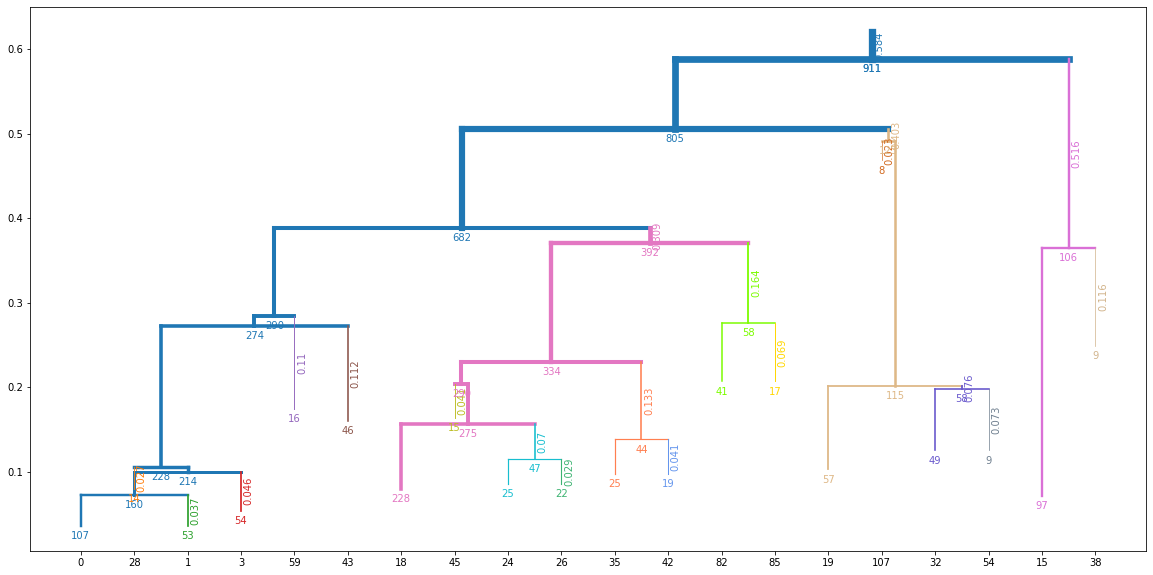

In [12]:
bars = draw_treeCluster(dfx, num_regs=num_categ, save=prefix+'tree.svg')

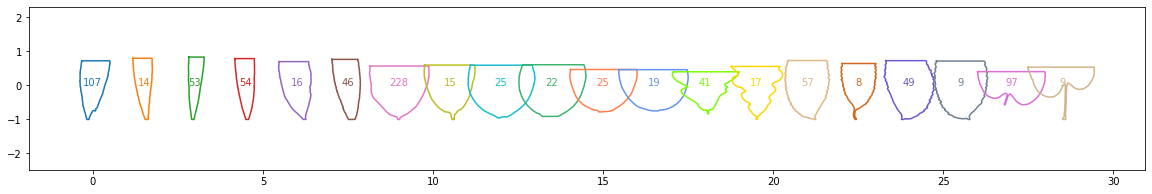

In [13]:
draw_tree_leaf(points, contours, bars, sam, save=prefix+'leaves.svg')

Text(0.5, 1.0, 'Method: ward')

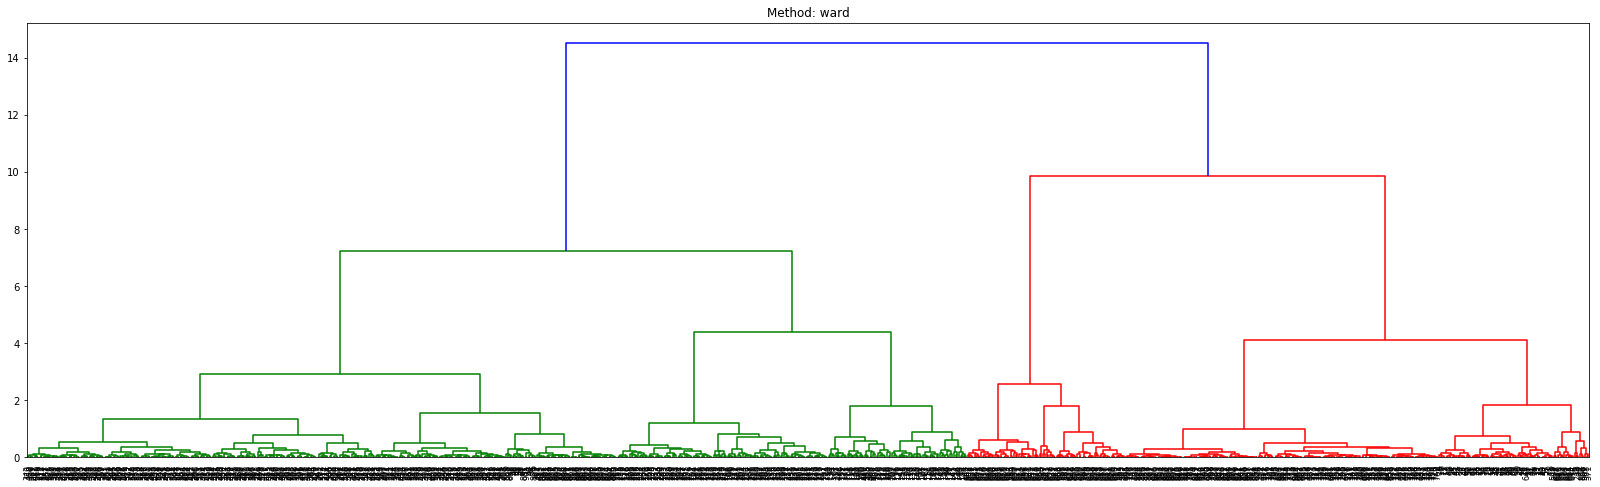

In [14]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
 
dfd = pd.DataFrame(points[:,0:3], columns=['x', 'y', 'z'])
fig = plt.figure(figsize=(28, 8))
Zx = linkage(dfd, 'ward')
dendrogram(Zx, leaf_font_size=8, labels=dfd.index)
plt.title('Method: ward')

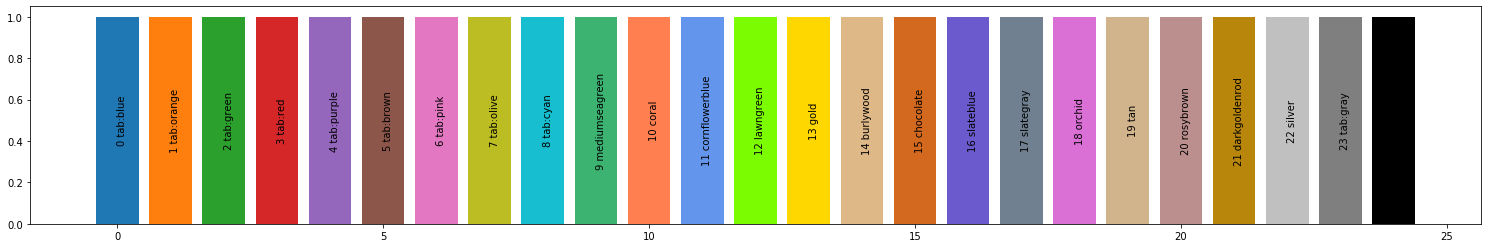

In [15]:
xx = list(range(25))
yy = [1]*len(xx)
fig = plt.figure(figsize=(26,4))
for i in range(len(yy)):
    plt.bar(xx[i],yy[i], color=palette[i])
    plt.text(i, 0.5, str(i)+' '+palette[i], va='center', rotation='vertical')